In [55]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')
from nltk.stem import SnowballStemmer
nltk.download('punkt')
stemmer = SnowballStemmer('portuguese')
import re
from unidecode import unidecode
from keras.regularizers import l2
from gensim.models import KeyedVectors
from tensorflow.keras import layers

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sp_au\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sp_au\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Pipeline 

In [56]:
# Base original da B2W, sem cortes + clean de overall_rating
b2wCorpus = pd.read_csv("B2W-Reviews01.csv",";",usecols=['review_text','overall_rating'],nrows=1000)

# Filtro
d = b2wCorpus.index[b2wCorpus["overall_rating"] < 1].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])
d = b2wCorpus.index[b2wCorpus["overall_rating"] > 5].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])

print(b2wCorpus.head)

<bound method NDFrame.head of      overall_rating                                        review_text
0                 4  Estou contente com a compra entrega rápida o ú...
1                 4  Por apenas R$1994.20,eu consegui comprar esse ...
2                 4  SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3                 4  MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4                 5  A entrega foi no prazo, as americanas estão de...
..              ...                                                ...
995               4  ASUS surpreendeu pela câmera de alta resolução...
996               3  TV show de bola! Tem aplicativos para entrada ...
997               1  Primeiro. Venderam um produto que não tinha no...
998               3  Produto bom entrega rápida gostei e recomendo ...
999               5  Recebi no prazo prometido. Muito bem embalado ...

[1000 rows x 2 columns]>


In [57]:
# Cleanning function
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
  text = unidecode(text)
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  text = re.sub("\d+", "", text)
  text = re.sub(r'(?:^| )\w(?:$| )', ' ', text).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [58]:
# Cleanning exec
b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: preprocess(x))

In [59]:
print(b2wCorpus.head)

<bound method NDFrame.head of      overall_rating                                        review_text
0                 4  contente compra entrega rapida unico problema ...
1                 4        apenas consegui comprar lindo copo acrilico
2                 4  supera agilidade praticidade outras panelas el...
3                 4          filho amou parece verdade tantos detalhes
4                 5  entrega prazo americanas estao parabens smart ...
..              ...                                                ...
995               4  asus surpreendeu camera alta resolucao embelez...
996               3  tv show bola aplicativos entrada youtube twitt...
997               1  primeiro venderam produto nao estoque segundo ...
998               3  produto bom entrega rapida gostei recomendo po...
999               5  recebi prazo prometido bem embalado satisfeito...

[1000 rows x 2 columns]>


In [60]:
b2wCorpus.overall_rating .value_counts().sort_index()

1    194
2     46
3    115
4    262
5    383
Name: overall_rating, dtype: int64

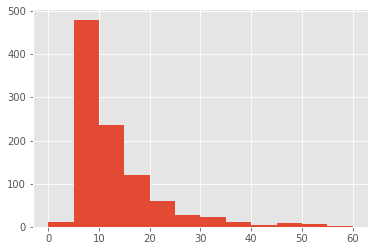

991


In [61]:
# histograma de palavras x qtd de linhas
Words = [len(linha.split()) for linha in b2wCorpus["review_text"] if len(linha.split()) <=60 ]
plt.style.use('ggplot')
plt.hist(Words, bins=[0,5,10,15,20,25,30,35,40,45,50,55,60])
plt.show()
print(len(Words))

In [62]:
# Partilha
b2wCorpus = b2wCorpus.sample(frac=1).reset_index(drop=True)
print(b2wCorpus.head)

<bound method NDFrame.head of      overall_rating                                        review_text
0                 5  otimo produto original chegou rapido nao probl...
1                 5  maravilhoso produto chegou antes prazo frete g...
2                 3  alem ter gostado produto gostei ainda prazo en...
3                 1  arrependi ter comprado acabamento mal feito ga...
4                 2  intalei filtro ponto agua sabesp pois nao tiro...
..              ...                                                ...
995               1  ate hoje nao recebi produto nao recomendo loja...
996               4  tudo certo chegou antes combinado embalagem or...
997               4  notebbok bom rapido pequeno leve quer notebook...
998               3  so nao pro celular pq camera frontal deixa des...
999               3  achei lindo conjunto pote vidro borracha verme...

[1000 rows x 2 columns]>


In [63]:
# Codifica
N =  200001
with open("cbow_s50.txt", "r",encoding='utf-8') as file:
    head = [next(file) for x in range(N)]

head[0] = str(N-1)+ " " + "50"+ "\n" # Conserta contagem de palavras
with open("word2vec_200k.txt", "w",encoding='utf-8') as file:
    for line in head:
        file.write(line)

def vocaIndex(lista, stem=False):
    for indice in range(len(lista)):
        text=lista[indice].lower()
        if text in model.vocab:
             lista[indice] = model.vocab[text].index
        else: 
             lista[indice] = '0'
    return lista

model = KeyedVectors.load_word2vec_format('word2vec_200k.txt')

def codifica(text, stem=False):
    tokens = nltk.word_tokenize(text)
    tokens = vocaIndex(tokens)
    return tokens

b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: codifica(x))

In [64]:
b2wCorpus['ord'] = b2wCorpus.apply(lambda row: len(row.review_text), axis=1)

In [65]:
b2wCorpus.shape

(1000, 3)

In [66]:
#b2wCorpus = b2wCorpus[b2wCorpus.ord != 0]
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord < 5].index)
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord > 50].index)

In [67]:
b2wCorpus.shape

(972, 3)

In [68]:
b2wCorpus.reset_index(drop=True, inplace=True)

In [69]:
b2wCorpus.head()

,overall_rating,review_text,ord
0,5,"[101071, 902, 1100, 428, 61637, 7804, 372, 612]",8
1,5,"[5984, 902, 428, 131, 566, 26012, 106655]",7
2,3,"[21469, 69, 19789, 902, 6376, 62, 566, 2499, 6...",16
3,1,"[73596, 69, 8201, 12871, 733, 382, 59529, 1065...",11
4,2,"[0, 12689, 233, 28129, 16145, 290, 7804, 3004,...",16


In [70]:
type(b2wCorpus.review_text)

pandas.core.series.Series

In [71]:
#b2wCorpus.review_text.str.rjust(width=50, fillchar='0')
#np.reshape(y_train,(-1))

b2wCorpus.review_text = keras.preprocessing.sequence.pad_sequences(b2wCorpus.apply(lambda row: np.reshape(row.review_text,(-1)), axis=1), maxlen=50, padding='post').tolist()

In [72]:
b2wCorpus.head()

,overall_rating,review_text,ord
0,5,"[101071, 902, 1100, 428, 61637, 7804, 372, 612...",8
1,5,"[5984, 902, 428, 131, 566, 26012, 106655, 0, 0...",7
2,3,"[21469, 69, 19789, 902, 6376, 62, 566, 2499, 6...",16
3,1,"[73596, 69, 8201, 12871, 733, 382, 59529, 1065...",11
4,2,"[0, 12689, 233, 28129, 16145, 290, 7804, 3004,...",16


In [73]:
# Função de split
def train_validate_test_split(df, train_percent=.65, validate_percent=.1, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [74]:
b2wCorpusTrain, b2wCorpusValidate, b2wCorpusTest = train_validate_test_split(b2wCorpus)

In [75]:
b2wCorpusTrain=b2wCorpusTrain.reindex(b2wCorpusTrain['ord'].sort_values(ascending=False).index)
b2wCorpusTrain.head()

,overall_rating,review_text,ord
961,1,"[9735, 902, 428, 566, 17382, 930, 2009, 902, 3...",50
229,1,"[9735, 3223, 1100, 117, 12783, 315, 8201, 2610...",49
72,1,"[7051, 0, 86, 18874, 141, 7804, 428, 14468, 20...",49
178,1,"[902, 7804, 978, 532, 138589, 2648, 5841, 7804...",46
836,4,"[20017, 1118, 363, 4104, 343, 635, 1108, 672, ...",46


In [76]:
b2wCorpusValidate=b2wCorpusValidate.reindex(b2wCorpusValidate['ord'].sort_values(ascending=False).index)
b2wCorpusValidate.head

<bound method NDFrame.head of      overall_rating                                        review_text  ord
488               3  [902, 3330, 1721, 1609, 1968, 18874, 141, 1629...   41
743               4  [245, 2294, 6451, 168, 8308, 7458, 7804, 7186,...   38
740               3  [62, 7804, 93207, 902, 290, 23685, 11016, 616,...   36
325               5  [8557, 3690, 2951, 3058, 3143, 1380, 7804, 0, ...   30
123               5  [775, 363, 2499, 4402, 0, 7804, 494, 39, 153, ...   28
..              ...                                                ...  ...
421               5  [226, 902, 8201, 3993, 22522, 0, 0, 0, 0, 0, 0...    5
419               5  [101071, 902, 22522, 88, 10760, 0, 0, 0, 0, 0,...    5
874               3  [667, 96, 1450, 902, 2426, 0, 0, 0, 0, 0, 0, 0...    5
571               5  [2104, 902, 3833, 0, 10986, 0, 0, 0, 0, 0, 0, ...    5
150               5  [902, 226, 8557, 3690, 112734, 0, 0, 0, 0, 0, ...    5

[97 rows x 3 columns]>

In [77]:
b2wCorpusTest=b2wCorpusTest.reindex(b2wCorpusTest['ord'].sort_values(ascending=False).index)
b2wCorpusTest.head

<bound method NDFrame.head of      overall_rating                                        review_text  ord
910               3  [0, 1481, 226, 7804, 902, 209, 566, 2499, 7804...   50
201               5  [950, 1069, 19328, 1087, 187622, 42542, 1713, ...   48
674               2  [7804, 5973, 5437, 7804, 185, 509, 7288, 439, ...   47
814               1  [9735, 6239, 4563, 17756, 20206, 40879, 6494, ...   46
505               1  [9735, 252, 12783, 234, 25236, 1101, 2217, 188...   46
..              ...                                                ...  ...
34                5  [2240, 226, 2499, 131, 566, 0, 0, 0, 0, 0, 0, ...    5
295               5  [2240, 226, 63700, 141676, 6472, 0, 0, 0, 0, 0...    5
455               4  [226, 122, 340, 22522, 2294, 0, 0, 0, 0, 0, 0,...    5
385               2  [70, 1049, 31424, 3561, 110, 0, 0, 0, 0, 0, 0,...    5
776               1  [62, 7804, 7256, 902, 8201, 0, 0, 0, 0, 0, 0, ...    5

[244 rows x 3 columns]>

In [78]:
type(b2wCorpus.review_text)

pandas.core.series.Series

In [85]:
# Treino, Validação e teste
RANDOM_SEED = 42
x_train = b2wCorpusTrain.review_text
y_train = b2wCorpusTrain.overall_rating
x_val = b2wCorpusValidate.review_text
y_val = b2wCorpusValidate.overall_rating

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=RANDOM_SEED)


print(x_train)

np.random.seed(RANDOM_SEED)
model = KeyedVectors.load_word2vec_format('word2vec_200k.txt')
emb = model.get_keras_embedding()

703    [902, 532, 63936, 631, 4035, 0, 0, 0, 0, 0, 0,...
572    [22522, 88, 1359, 21139, 349, 508, 2692, 10107...
970    [5841, 7804, 2142, 2989, 31839, 37822, 8721, 1...
669    [5841, 635, 803, 0, 61, 3378, 9735, 0, 0, 0, 0...
915    [565, 1083, 10134, 9735, 24074, 57347, 39, 902...
                             ...                        
634    [127381, 161274, 0, 11437, 36864, 54465, 1029,...
864    [226, 86, 7804, 98124, 902, 5841, 1643, 2120, ...
644    [902, 2692, 1316, 4133, 22522, 106, 7804, 0, 1...
115    [902, 161274, 532, 2499, 2789, 85324, 2789, 22...
905    [2532, 1968, 35612, 316, 7804, 6376, 7804, 540...
Name: review_text, Length: 441, dtype: object


In [86]:
prob = 0.5
SEQUENCE_MAXLEN = 50
model = keras.Sequential()
model.add(layers.Input(shape=(SEQUENCE_MAXLEN, )))
model.add(emb)
model.add(layers.LSTM(128, dropout=prob))
model.add(keras.layers.Dense(5, activation='softmax'))
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=8, epochs=10, validation_data=(x_val, y_val)
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

In [ ]:

#Tokenizando
vectorize_layer = TextVectorization(                                      
                                        standardize='lower_and_strip_punctuation',
                                        split='whitespace',
                                        output_mode='int',
                                        pad_to_max_tokens=False,
                                        output_sequence_length=75
                                        )
vectorize_layer.adapt(x_train)
vocab_size = len(vectorize_layer.get_vocabulary())
print(vocab_size)